In [1]:
import numpy as np
import matplotlib as plt
import os 
import timeit
from scipy.stats import uniform

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np

import sys
sys.path.append('../../tests/Xaccelerometer_geometric/models')

# Import the function coarse_model
from coarse_model import *

Define help function to compute the total stiffness

In [2]:
def compute_stiffness(w, th , E , l1 , l2 , oe): 
    """
    Inputs:
    w - Beam width
    th - Beam thickness 
    E - Young's modulus of the beam material
    l1 - Length of the longer beams
    l2 - Length of the shorter beams
    oe - Overetch affecting the effective width of the beam

     Output:
     kTotal - Total stiffness of the folded beam structure
    """
    effectiveWidth = w - 2*oe
    J = (1/12) * th * effectiveWidth**3
    #Stiffness of individual beams based on their length
    k1 = 12 * E * J / (l1**3 * 4)
    k2 = 12 * E * J / (l2**3 * 2)
    kTotal = 2 / (1/k1 + 1/k2)
    
    return kTotal


In [3]:
def fringing_coeff( G, W ,L):
    return (1+ G/np.pi/W + G/np.pi/W*np.log(2*np.pi*W/G))*(1+ G/np.pi/L + G/np.pi/L*np.log(2*np.pi*L/G))
    
    

In [4]:
w0 = np.array([
       -5.46838380e-02, -5.48967794e-02, -5.55854514e-02, -5.69293946e-02,
       -6.15979917e-02, -6.96645826e-02, -8.53587836e-02, -1.13584198e-01,
       -1.55779019e-01, -2.17224211e-01, -2.89895594e-01, -3.72584194e-01,
       -4.60936368e-01, -5.41136026e-01, -6.05785012e-01, -6.33480668e-01,
       -6.19262516e-01, -5.53423703e-01, -4.28976476e-01, -2.45728046e-01,
       -1.18095540e-02,  2.58471608e-01,  5.44585645e-01,  8.23014259e-01,
        1.06804001e+00,  1.25755286e+00,  1.38050044e+00,  1.42790329e+00,
        1.40554321e+00,  1.32398021e+00,  1.20541465e+00,  1.05884898e+00,
        8.86592448e-01,  6.83821023e-01,  4.60522562e-01,  2.31037945e-01,
       -5.70054632e-04, -2.24628627e-01, -4.35439378e-01, -6.25737846e-01,
       -7.88053155e-01, -9.16048288e-01, -1.00675571e+00, -1.06351376e+00,
       -1.08169496e+00, -1.07077491e+00, -1.03711855e+00, -9.94023323e-01,
       -9.51916993e-01, -9.19640779e-01, -8.97413194e-01, -8.88098419e-01,
       -8.84706736e-01, -8.82587194e-01, -8.70208561e-01, -8.37450683e-01,
       -7.73694575e-01, -6.70147836e-01, -5.18874586e-01, -3.20481181e-01,
       -7.85847083e-02,  1.94332868e-01,  4.81066912e-01,  7.56015182e-01,
        9.96855795e-01,  1.18446314e+00,  1.30417430e+00,  1.34975564e+00,
        1.32360113e+00,  1.24206936e+00,  1.11802256e+00,  9.73114133e-01,
        7.96541691e-01,  6.01413965e-01,  3.87530953e-01,  1.66534051e-01,
       -5.83987348e-02, -2.76883483e-01, -4.82963532e-01, -6.68263495e-01,
       -8.27728570e-01, -9.52925146e-01, -1.04211688e+00, -1.09318089e+00,
       -1.10869455e+00, -1.08746517e+00, -1.03708637e+00, -9.64633644e-01,
       -8.79197538e-01, -7.87804663e-01, -6.94566667e-01, -6.03279769e-01,
       -5.14187515e-01, -4.30457652e-01, -3.52577776e-01, -2.81432003e-01,
       -0.21902496, -0.16362718, -0.11842529, -0.0839361 , -0.05877977,
       -0.04311477, -0.0356038 , -0.0343717 , -0.04091887, -0.0441989 ,
       -0.05398948, -0.06047267, -0.070446  , -0.07894647, -0.08656528,
       -0.09359398, -0.09992059, -0.10565532, -0.10747549, -0.10939648,
       -0.11117665, -0.10993127, -0.10891264, -0.10737673, -0.10464664,
       -0.10177431, -0.09841612, -0.09430341, -0.09072948, -0.08698898,
       -0.08338045, -0.08009314, -0.07784703, -0.07413474, -0.07164513,
       -0.07049834, -0.06917841, -0.06577135, -0.06452557, -0.06314325,
       -0.06243589, -0.06056603, -0.06046208, -0.05954407, -0.05914033,
       -0.05995621, -0.05923726, -0.05893051, -0.05853039, -0.05816014,
       -0.0574123 , -0.05714226, -0.0570005 , -0.0569686 ]
        )



In [5]:
w1 = np.array([7.70296335e-01, 7.70759165e-01, 7.70844460e-01, 7.70721376e-01,
       7.69156337e-01, 7.68131554e-01, 7.65174866e-01, 7.58141637e-01,
       7.48862624e-01, 7.31319487e-01, 7.16895878e-01, 7.02043295e-01,
       6.83882356e-01, 6.70020282e-01, 6.55230105e-01, 6.53583586e-01,
       6.57113135e-01, 6.67445719e-01, 6.87399030e-01, 7.19669342e-01,
       7.64909625e-01, 8.24381292e-01, 9.00411844e-01, 9.93627608e-01,
       1.10344493e+00, 1.22517502e+00, 1.35730124e+00, 1.48168850e+00,
       1.58601487e+00, 1.64787626e+00, 1.65860808e+00, 1.61445642e+00,
       1.51164794e+00, 1.34585547e+00, 1.13929117e+00, 9.23234344e-01,
       7.15993524e-01, 5.33042789e-01, 3.77927899e-01, 2.51210898e-01,
       1.53314725e-01, 8.36797208e-02, 4.10641879e-02, 1.99973490e-02,
       2.84919366e-02, 6.01814389e-02, 1.13957725e-01, 1.79770574e-01,
       2.49763817e-01, 3.16651165e-01, 3.82201552e-01, 4.40317333e-01,
       4.95554537e-01, 5.43817461e-01, 5.88401258e-01, 6.28514171e-01,
       6.67115569e-01, 7.04657853e-01, 7.44365156e-01, 7.86359251e-01,
       8.37098360e-01, 8.99342299e-01, 9.76662040e-01, 1.06663561e+00,
       1.17103696e+00, 1.28906727e+00, 1.41228676e+00, 1.52738297e+00,
       1.61504674e+00, 1.66400385e+00, 1.65247071e+00, 1.59717786e+00,
       1.47445822e+00, 1.30778909e+00, 1.10509360e+00, 8.93734276e-01,
       6.88796461e-01, 5.06941855e-01, 3.52603257e-01, 2.27826789e-01,
       1.29971921e-01, 6.07080124e-02, 1.76058263e-02, 1.00801419e-03,
       7.81397615e-03, 4.33648415e-02, 1.00349553e-01, 1.72105774e-01,
       2.48899922e-01, 3.25683475e-01, 3.99538845e-01, 4.67896134e-01,
       5.32739997e-01, 5.91235638e-01, 6.44264936e-01, 6.91527247e-01,
       0.7317261 , 0.76765615, 0.79366785, 0.8101723 , 0.81885713,
       0.8198994 , 0.8143184 , 0.80478585, 0.7882982 , 0.7812978 ,
       0.76776284, 0.76209384, 0.7528379 , 0.7469036 , 0.7426898 ,
       0.7392677 , 0.7364249 , 0.73363554, 0.7358924 , 0.73676556,
       0.7365562 , 0.73988754, 0.74173874, 0.74344456, 0.74608564,
       0.7482979 , 0.75070864, 0.7539025 , 0.7560142 , 0.75822383,
       0.76025784, 0.7617975 , 0.76185554, 0.7644145 , 0.76531583,
       0.76434743, 0.7639876 , 0.76720524, 0.7672523 , 0.7678288 ,
       0.7675803 , 0.76938194, 0.7685974 , 0.769236  , 0.7692172 ,
       0.7673927 , 0.76808155, 0.7681907 , 0.7685097 , 0.7688019 ,
       0.7697169 , 0.76991284, 0.7699335 , 0.76977706]

)

In [6]:
w2 = np.array(
    [ 1.1795405e-03,  1.1840451e-03,  1.1959869e-03,  1.2207277e-03,
        1.2990178e-03,  1.4365296e-03,  1.7058086e-03,  2.1724852e-03,
        2.8809647e-03,  3.9416105e-03,  5.2604810e-03,  6.8700342e-03,
        8.7222764e-03,  1.0628401e-02,  1.2483117e-02,  1.3960212e-02,
        1.4952241e-02,  1.5281168e-02,  1.4801122e-02,  1.3477816e-02,
        1.1376112e-02,  8.6813606e-03,  5.6756926e-03,  2.6986429e-03,
        1.2146129e-04, -1.7559405e-03, -2.8362253e-03, -3.0895281e-03,
       -2.7415555e-03, -2.0914837e-03, -1.5538209e-03, -1.2771582e-03,
       -1.2379606e-03, -1.2190365e-03, -1.1613212e-03, -1.0383708e-03,
       -6.7628775e-04, -4.5896399e-05,  8.8538841e-04,  2.0719501e-03,
        3.4131925e-03,  4.7814972e-03,  6.0838331e-03,  7.2897766e-03,
        8.2584750e-03,  9.0717841e-03,  9.7897043e-03,  1.0531691e-02,
        1.1325627e-02,  1.2263296e-02,  1.3308296e-02,  1.4508674e-02,
        1.5769836e-02,  1.7029645e-02,  1.8130491e-02,  1.8930821e-02,
        1.9268043e-02,  1.9004608e-02,  1.8005772e-02,  1.6263932e-02,
        1.3815512e-02,  1.0835455e-02,  7.5779622e-03,  4.4179284e-03,
        1.6845005e-03, -3.6425062e-04, -1.5768342e-03, -1.9620121e-03,
       -1.7005323e-03, -1.1641773e-03, -6.2782411e-04, -4.3140151e-04,
       -3.6799020e-04, -4.8707327e-04, -5.7336641e-04, -5.6046143e-04,
       -2.7708180e-04,  2.9348352e-04,  1.1843614e-03,  2.3299623e-03,
        3.6599853e-03,  5.0171125e-03,  6.3271364e-03,  7.4718776e-03,
        8.4157949e-03,  9.0739280e-03,  9.5237447e-03,  9.7771920e-03,
        9.8182894e-03,  9.6886335e-03,  9.3794167e-03,  8.9296196e-03,
        8.3289687e-03,  7.6236730e-03,  6.8304148e-03,  5.9782993e-03,
       0.00511369, 0.00423774, 0.00342795, 0.00269901, 0.00207221,
       0.00156748, 0.00118178, 0.00089505, 0.00075626, 0.00059919,
       0.00057483, 0.00054736, 0.00061048, 0.00068231, 0.00077182,
       0.00088519, 0.00100494, 0.00113517, 0.00122551, 0.00132268,
       0.00141375, 0.00146179, 0.00151491, 0.0015564 , 0.00157324,
       0.00158186, 0.00157688, 0.0015539 , 0.0015331 , 0.00150503,
       0.00147514, 0.00144507, 0.00142254, 0.00138213, 0.00134833,
       0.00133906, 0.00132623, 0.00127886, 0.00126368, 0.00124628,
       0.00123883, 0.00121707, 0.00121424, 0.00120479, 0.00120179,
       0.00121585, 0.00120763, 0.00120626, 0.00120406, 0.00120137,
       0.00119406, 0.00119282, 0.00119344, 0.00119479]


)


In [7]:
def coarse_model_adj(params):
    """
    - Inputs:
    - parameters[0] : Overetch 
    - parameters[1] : Offset
    - parameters[2] : Thickness

    - Output:
    - C : An array containing the computed difference of capacitance 
    """
    # Time parameters
    t0 = 0                    # Initial time.
    tf = 0.0015-1e-5          # Final time.
    dt =1e-5                  # Time step size.

    # Stiffness parameters
    l1 = 221.4*1e-6              # Lenght of the longer beam 
    l2 = 110*1e-6            # Length of the shorted beam
    E  = 160*1e9               # Young Modulus 
    w  = 2.8*1e-6              # Width 

    # Force parameters 
    phi = lambda t: 0.9*(1-np.cos(2*np.pi*2500*t)) if t < 2/2500 else 0 # Voltage in the right electrodes
    s   = 101*1e-6             # param for the surface 
    dp  =1.2*1e-6                # Distance from the plates with Overetch and Offset = 0 

    # Mass parameters
    rho = 2320                 # Density of the mass.
    A   = 84*1e-9              # Area of the component

    # Damping parameters 
    alpha = 31440            # Damping coefficient alpha. 31400
    beta  =  0               # Damping coeff beta 

    # Input Parameters 
    oe = params[0]*1e-6
    of = params[1]*1e-6
    th = params[2]*1e-6 # ricorda di rimettere 6
   
    eps0 = 8.854*1e-12       # Dielectric permittivity constant
    eps1 = 1.000             # Relative dielectric permittivity of air.

    # Compute the distance between the faces of electrodes and the sensor
    dl = dp+2*oe+of
    dr = dp+2*oe-of
    # Compute the surface of the electrode 
    S = th * (s - 2*oe) * 10  # multiply by ten since we have 10 condensators
    
    # Initial conditions
    u0 = 0  # Initial displacement
    v0 = 0  # Initial velocity
    N = int((tf - t0) / dt)

    # Initialization
    u = np.zeros((N+1))  # displacement
    v = np.zeros((N+1))  # velocity
    C = np.zeros((N+1))  # capacitance
    u[0] = u0
    v[0] = v0
    C[0] = eps1*eps0*S*(1/(dr)*fringing_coeff( dr, s-2*oe ,th) - 1/(dl)*fringing_coeff( dl, s-2*oe ,th))

    # Compute the stiffness
    k = compute_stiffness(w, th , E , l1 , l2 , oe) 
   
    # Compute mass
    m = rho * A * th
    # Compute Damping 
    damp = alpha* m + beta* k

    # Precompute phi values to avoid redundant computation
    k1 =  0.5 * eps0 * eps1 * S
    k2 = eps1*eps0*S
    F_values = np.array([phi(n * dt) for n in range(N)])**2 * k1

    # Time-stepping loop using Forward Euler scheme
    for n in range(N) :
        u_n = u[n]
        v_n = v[n]
        u_new = u_n + dt * v_n
        # Compute the value of the input voltage at time t = n*dt 
        F = F_values[n]/((dr-u_n)**2)
        v[n+1] = v_n + dt * ( F - damp*v_n - k*u_n )/m
        # Compute the difference of capacitance
        C[n+1] = k2*(1/(dr-u_new)*fringing_coeff( dr-u_new, s-2*oe ,th) - 1/(dl+u_new)*fringing_coeff( dl+u_new, s-2*oe ,th))
        u[n+1] = u_new
    
    # Adjusting phase 
    C = C*1.02*1e15 + w0*params[0] + w1*params[1] + w2*params[2]

    return C

# Compare the model with the exact solutions

Select the true samples on which we want to test the corse model

In [8]:
# Standard library imports
import sys
# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')
from utils import * 

# Surrogate Model Configurations
CONFIGURATION_I = './config_I.json'
data_processor_I = preprocessing(CONFIGURATION_I)

# Extract test data 
X_values, y_values = data_processor_I.X_test, data_processor_I.y_test

# Which sample of the training set do wou want to take as experimental input?
sample = [5,11, 22, 38, 154]

# Select a true sample for testing
x_true, y_true = X_values[sample], y_values[sample]
print('        Overetch,   Offset,   Thickness')
x_true


        Overetch,   Offset,   Thickness


array([[ 2.3053600e-01, -6.8871000e-02,  3.0351452e+01],
       [ 4.5057900e-01, -4.4200000e-04,  2.9471304e+01],
       [ 1.5078200e-01, -6.1468000e-02,  3.0962383e+01],
       [ 2.6249600e-01, -2.7814000e-02,  2.9626475e+01],
       [ 4.8182800e-01, -4.7104400e-01,  2.9200776e+01]])

Perform comparisons with different types of inputs of parameters 

The parameters used are: [ 0.230536 -0.068871 30.351452]


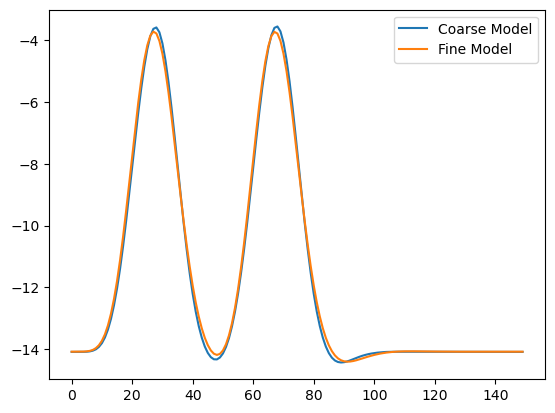

-14.089086995520503
The parameters used are: [ 4.5057900e-01 -4.4200000e-04  2.9471304e+01]


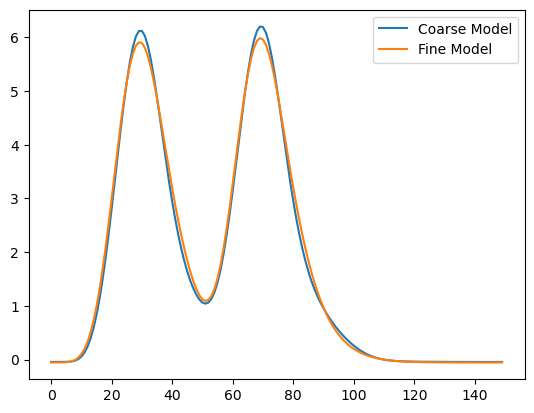

-0.04493199632158809
The parameters used are: [ 0.150782 -0.061468 30.962383]


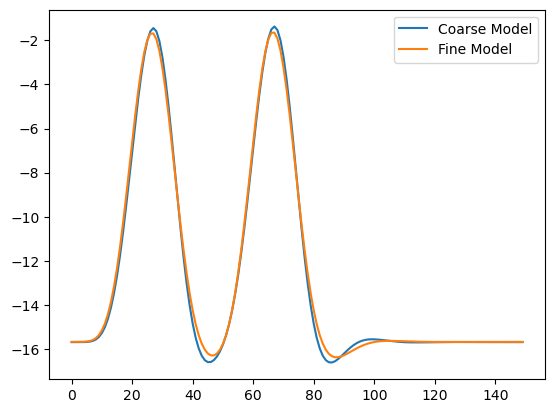

-15.675761065008224
The parameters used are: [ 2.6249600e-01 -2.7814000e-02  2.9626475e+01]


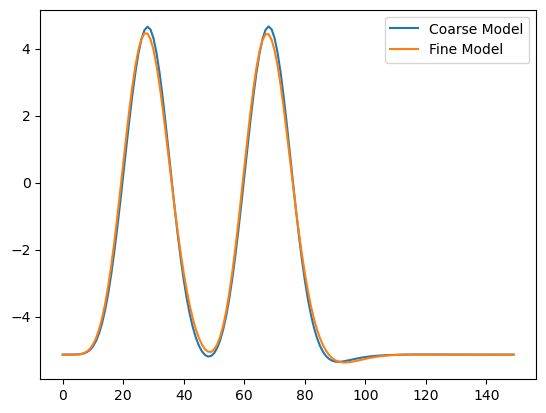

-5.134908421770849
The parameters used are: [ 0.481828 -0.471044 29.200776]


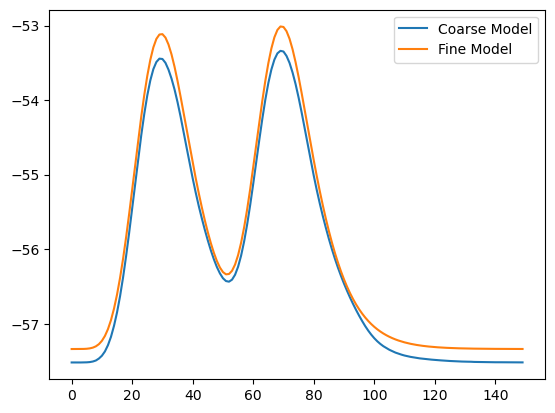

-57.52011571100089
Mean absolute percentage error for the simulations are:
 [0.01041476 0.04580999 0.01416338 0.02856778 0.00344433]


In [9]:
ratio = []
for index, x in enumerate(x_true):
    print('The parameters used are:' , x)
    res = coarse_model_adj(x) 
    
    plt.plot(res)
    plt.plot(y_true[index])
    plt.legend(['Coarse Model', 'Fine Model'])
    plt.show()
    print(res[0])
    #print(res/y_true[0])
    ratio.append(  np.linalg.norm((res - y_true[index]), ord=1)  / np.linalg.norm(( y_true[index]), ord=1) )

#plt.plot(y_true[-1]-res)
#plt.show()
print('Mean absolute percentage error for the simulations are:\n', np.array(ratio) ) 
    

# Train the adjusting coefficients 

In [10]:
# Collecting traing and Testing Data
X_train = data_processor_I.X_train
X_test = data_processor_I.X_test
y_train = data_processor_I.y_train
y_test = data_processor_I.y_test

In [11]:
coarse_y_train = []
coarse_y_test = []
for x in X_train:  
    coarse_y_train.append(coarse_model(x))
for x in X_test:
    coarse_y_test.append(coarse_model(x))

# Concatenate input parameters and coarse solutions
X_train_combined = np.concatenate((X_train, coarse_y_train), axis=1)
X_test_combined = np.concatenate((X_test, coarse_y_test), axis=1)

In [12]:
Training = False

num_samples = 640
num_parameters = 3
num_coarse_values = 150

# Define the initial weighsts matrix 
weight_matrix = [ np.vstack([np.zeros((3,150)), np.eye(150)] ),  np.zeros(150) ]
#weight_matrix = [ np.vstack([w0,w1,w2, np.eye(150)] ),  np.zeros(150) ]

# Define the neural network model
model_adj_NN = Sequential([
        Dense(150, input_shape=(num_parameters + num_coarse_values,),activation='linear')
       ])

def custom_loss(y_true, y_pred):
    # Calculate loss for the coarse solution
    coarse_loss = tf.reduce_mean(tf.square(y_pred - y_true))
    
    # Add regularization term to penalize changes in the weights of the coarse solution
    regularization_loss = tf.reduce_mean(tf.square(model_adj_NN.layers[0].weights[0][3:] - np.eye(150)))
    
    # Total loss
    total_loss = coarse_loss + regularization_loss*1e5
    return total_loss

# Set the initial weights for the dense layer
model_adj_NN.layers[0].set_weights(weight_matrix)

weight_to_freeze = np.vstack( (  np.ones((3,150)), np.zeros((150,150))  )  ).astype(int)
#model_adj_NN.layers[0].trainable_weights[0][weight_to_freeze] = 0  # Set the weights to fix to zero
#print(model_adj_NN.layers[0].trainable_weights[0][3:])

if Training: 
       
       # Define the optimizer with an initial learning rate
       initial_learning_rate = 1e-4
       optimizer = Adam(learning_rate=initial_learning_rate) 

       # Compile the model with the optimizer
       model_adj_NN.compile(optimizer=optimizer, loss= custom_loss) #'mean_squared_error')

       # Define a learning rate scheduler
       learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=500, min_lr=1e-6)

       # Concatenate input parameters and coarse solutions
       X_train_combined = np.concatenate((X_train, coarse_y_train), axis=1)
       X_test_combined = np.concatenate((X_test, coarse_y_test), axis=1)
    

       # Train the model
       model_adj_NN.fit(X_train_combined, y_train, epochs = 10000, batch_size=32, validation_data= (X_test_combined, y_test), callbacks=learning_rate_scheduler)

       model_adj_NN.save('./models/model_adj_NN.keras')


# Load the model
#model_adj_NN = load_model('./models/model_adj_NN.keras')

Epoch 1/10000


/Users/lucacaroselli/miniconda3/envs/bima/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2807 - val_loss: 0.1082 - learning_rate: 1.0000e-04
Epoch 2/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0610 - val_loss: 0.0363 - learning_rate: 1.0000e-04
Epoch 3/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0251 - val_loss: 0.0194 - learning_rate: 1.0000e-04
Epoch 4/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0157 - val_loss: 0.0161 - learning_rate: 1.0000e-04
Epoch 5/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0128 - val_loss: 0.0138 - learning_rate: 1.0000e-04
Epoch 6/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0110 - val_loss: 0.0164 - learning_rate: 1.0000e-04
Epoch 7/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 8/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0123 - val_loss: 0.0126 - learning_rate: 1.0000e-04
Epoch 9/10000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0115 - val_loss: 0.0127 - learn

KeyboardInterrupt: 

In [ ]:
model_adj_NN.layers[0].weights[0][0][96:]

<tf.Tensor: shape=(54,), dtype=float32, numpy=
array([-0.21902496, -0.16362718, -0.11842529, -0.0839361 , -0.05877977,
       -0.04311477, -0.0356038 , -0.0343717 , -0.04091887, -0.0441989 ,
       -0.05398948, -0.06047267, -0.070446  , -0.07894647, -0.08656528,
       -0.09359398, -0.09992059, -0.10565532, -0.10747549, -0.10939648,
       -0.11117665, -0.10993127, -0.10891264, -0.10737673, -0.10464664,
       -0.10177431, -0.09841612, -0.09430341, -0.09072948, -0.08698898,
       -0.08338045, -0.08009314, -0.07784703, -0.07413474, -0.07164513,
       -0.07049834, -0.06917841, -0.06577135, -0.06452557, -0.06314325,
       -0.06243589, -0.06056603, -0.06046208, -0.05954407, -0.05914033,
       -0.05995621, -0.05923726, -0.05893051, -0.05853039, -0.05816014,
       -0.0574123 , -0.05714226, -0.0570005 , -0.0569686 ], dtype=float32)>

# Compare Coarse and Fine model 


Load fine model 

In [13]:
# Initialize and load model
model_I = NN_Model()
model_I.load_model(data_processor_I.config['MODEL_PATH'])

# Define forward function
forward_model = create_forward_model_function(data_processor_I, model_I)

Compare fine and coarse model on the paramters x

In [15]:
# Define parameters x
X = np.random.uniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]), size=[1000,3])
# RMB: lower_bound= [0.1, -0.5, 29.0],  upper_bound=[0.5, 0.5, 31.0]

start_time = timeit.default_timer()
res_coarse = [coarse_model_adj(X[i,:]) for i in range(1000)]  
end_time = timeit.default_timer()

res_fine = [forward_model(X[i,:]) for i in range(1000)] 
end_time2 = timeit.default_timer()

print('Time Coarse', end_time-start_time)
print('Time fine', end_time2-end_time)




Time Coarse 1.0266109160002088
Time fine 38.71975554199889
